# Animate average dock fullness, over an entire day

In [149]:
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pickle
import datetime
data_path = './data'

# Area we're looking at
north,south,east,west = 40.84,40.63,-73.865,-74.040

# Construct base for plot

In [2]:
# Import streets area of interest, save as ESRI shapefile. Then load. 

#north,south,east,west = 40.84,40.63,-73.865,-74.040
#G = ox.core.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True, retain_all=False, 
#                            truncate_by_edge=False)
#ox.save_load.save_graph_shapefile(G, filename='nyc_streets.shp', folder=data_path, encoding='utf-8')

nyc_streets = gpd.read_file(os.path.join(data_path,'nyc_streets.shp','edges','edges.shp'))
nyc_streets = nyc_streets.to_crs({'init': 'epsg:4326'})

In [40]:
from general_functions import save_pkl, load_pkl
dock_dict = load_pkl(os.path.join(data_path,'dock_dict.pkl'))

dock_ids,dock_name,dock_lat,dock_lon = [],[],[],[]
for dock_id in dock_dict.keys():
    dock_ids.append(int(dock_id))
    dock_name.append(dock_dict[dock_id]['dock_name'])
    dock_lat.append(dock_dict[dock_id]['lat'])
    dock_lon.append(dock_dict[dock_id]['lon'])
coords = list(zip(dock_lon, dock_lat))

dock_df = pd.DataFrame({
    'dock_id': dock_ids,
    'dock_name': dock_name,
    'coords':coords
})

dock_df['coords'] = dock_df['coords'].apply(Point)
dock_gdf = gpd.GeoDataFrame(dock_df,geometry='coords')
dock_gdf.crs = {'init': 'epsg:4326'}

Text(68.5, 0.5, 'Latitude (deg)')

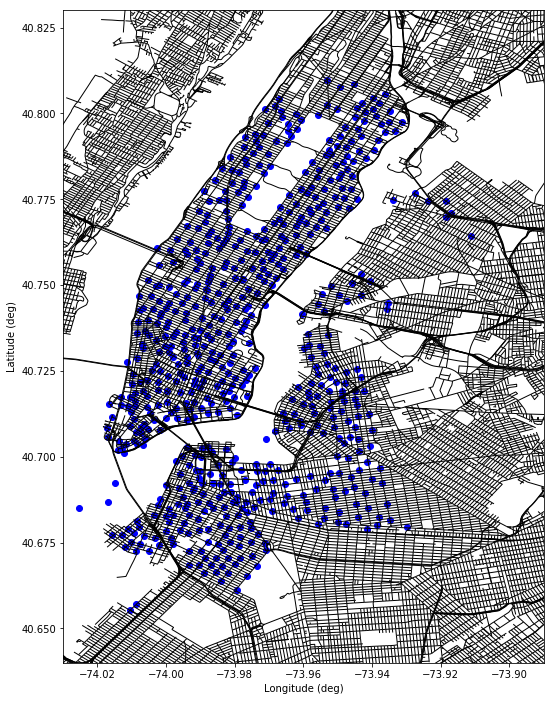

In [28]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111)
nyc_streets.plot(ax=ax, color='k',linewidth=1,alpha=1)
dock_gdf.plot(ax=ax,color='b')
ax.set_xlim([-74.030, -73.89])
ax.set_ylim([40.64, 40.83])
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# At a single time on a single day, plot percent_full for all docks

In [100]:
# Query the database for counts at all stations for single day. 
day = '2018-05-03'
day_p1 = '2018-05-04'
sql_query = "SELECT * FROM dock_counts WHERE date_time >= '"+day+" 00:00:00' AND date_time < '"+day_p1+" 00:00:00'"

import sqlalchemy
from external_variables import sql_un,sql_pwd
database_username = sql_un
database_password = sql_pwd
database_ip       = 'localhost'
database_name     = 'citi_bike'
conn_alchemy      = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                             format(database_username, database_password, 
                                                    database_ip, database_name)).connect()

daily_counts = pd.read_sql(sql_query,conn_alchemy,index_col='row_id',parse_dates=['date_time'])

conn_alchemy.close()

In [153]:
def plot_nyc_base(nyc_streets,time=None,size=11):
    fig = plt.figure(figsize=[size,size])
    ax = fig.add_subplot(111)
    nyc_streets.plot(ax=ax, color='k',linewidth=1,alpha=0.35)
    ax.set_xlim([-74.030, -73.92])
    ax.set_ylim([40.64, 40.83])
    ax.set_xlabel('Longitude (deg)')
    ax.set_ylabel('Latitude (deg)')
    if time is not None: 
        plt.text(-73.995,40.824,str(time),fontsize=22,alpha=1,color='b')
    return fig,ax

# If directory to save these figs doesn't exist, create it! 
if not os.path.isdir('./figs/gifs'): 
    os.mkdir('./figs/gifs')

# Plot fraction_full, empty, full at each dock, for each hour during a single day. 
from scipy.interpolate import interp1d
base_time = pd.Timestamp(year=2000,month=1,day=1)
time_delta = pd.Timedelta('1 hours')
times = pd.date_range(day, periods=24, freq='H')[1:]

for time in times: 

    dock_frac_full = dock_gdf
    ff,nb,nd = [],[],[]

    for _,row in dock_frac_full.iterrows():
        dock_id = row['dock_id']
        dc_dock = daily_counts[daily_counts['dock_id'] == dock_id].sort_values('date_time')

        if len(dc_dock.index) > 0: 

            dc_dock['frac_full'] = dc_dock['avail_bikes']/(dc_dock['avail_bikes']+dc_dock['avail_docks'])
            dc_dock['hours_2000'] = (dc_dock['date_time']-base_time)/time_delta

            interp_ff = interp1d(dc_dock['hours_2000'],dc_dock['frac_full'],kind='nearest',bounds_error=False)
            ff.append(float(interp_ff((time-base_time)/time_delta)))

            interp_nb = interp1d(dc_dock['hours_2000'],dc_dock['avail_bikes'],kind='nearest',bounds_error=False)
            nb.append(float(interp_nb((time-base_time)/time_delta)))

            interp_nd = interp1d(dc_dock['hours_2000'],dc_dock['avail_docks'],kind='nearest',bounds_error=False)
            nd.append(float(interp_nd((time-base_time)/time_delta)))

        else: 
            ff.append(np.NaN)
            nb.append(np.NaN)
            nd.append(np.NaN)
    
    dock_frac_full['frac_full'] = ff
    dock_frac_full['avail_bikes'] = nb
    dock_frac_full['avail_docks'] = nd
    
    # Plot fraction full
    frac_full = dock_frac_full[np.isnan(dock_frac_full['frac_full']) == 0]
    fig,ax = plot_nyc_base(nyc_streets,time)
    frac_full.plot(ax=ax,column='frac_full',markersize=40,cmap='RdYlGn',legend=True,alpha=1)
    
    time_str = datetime.datetime.strftime(time,'%Y_%m_%d_%H_%M_%S')
    fig.savefig(os.path.join('./figs','gifs','frac_full_'+time_str+'.jpg'), bbox_inches='tight')
    plt.close(fig)
    
    # Plot which docks are empty and full
    #full_docks = dock_frac_full[dock_frac_full['avail_docks'] == 0]
    #empty_docks = dock_frac_full[dock_frac_full['avail_bikes'] == 0]
    #fig,ax = plot_nyc_base(nyc_streets,time)
    #full_docks.plot(ax=ax,color='g',markersize=40,alpha=1)
    #empty_docks.plot(ax=ax,color='r',markersize=40,alpha=1)
    #plt.text(-74.0275,40.650,'FULL',fontsize=22,alpha=1,color='g')
    #plt.text(-74.0275,40.6425,'EMPTY',fontsize=22,alpha=1,color='r')
    #
    #fig.savefig(os.path.join('./figs','gifs','full_empty_'+time_str+'.jpg'), bbox_inches='tight')
    #plt.close(fig)


In [168]:
# Create gif
import imageio
jpg_dir = './figs/gifs'
kargs = { 'fps': 3, 'subrectangles':True }

# frac_full maps
images = []
for file_name in sorted(os.listdir(jpg_dir)):
    if file_name.startswith('frac'):
        file_path = os.path.join(jpg_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join('./figs','frac_full.gif'), images, **kargs)

# full_empty maps
images = []
for file_name in sorted(os.listdir(jpg_dir)):
    if file_name.startswith('full'):
        file_path = os.path.join(jpg_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join('./figs','full_empty.gif'), images, **kargs)